##  This notebook is used to adjust Uganda National Communication emissions pathways for biomass emissions reallocation to energy

- Iterative notebook--first pass is on Thursday, August 14 2025
- Use results from ```emission_targets_uganda_inventory_aggregates``` notebook to reassign emissions while preserving net balance

In [2]:
# can comment out warnings.filterwarnings if you want to see warnings
import warnings
warnings.filterwarnings("ignore")

# only if you don't have the environment set up and you're lazy like me
import sys
dir_git = "/Users/usuario/git/sisepuede"
if dir_git not in sys.path:
    sys.path.append(dir_git)

import sisepuede.manager.sisepuede_examples as sxl
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.plotting.plots as spp
import sisepuede.utilities._toolbox as sf

import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import pathlib
import time
from typing import *

plt.style.use("dark_background", )


logger = None



In [35]:

# instantiate sispeuede classes
examples = sxl.SISEPUEDEExamples()
file_struct = sfs.SISEPUEDEFileStructure()

# derivate info
df_examples = examples("input_data_frame")
matt = file_struct.model_attributes

In [180]:
# fields
_FIELD_ADJ_FRAC_ALLOCATIONS_INEN = "frac_allocation_inen"
_FIELD_ADJ_FRAC_ALLOCATIONS_SCOE = "frac_allocation_scoe"
_FIELD_ADJ_FRST_SEQ = "forest_seq_mt_co2e"
_FIELD_ADJ_REMOVALS_TO_ALLOCATE = "total_removals_to_reallocate_mt_co2e"
_FIELD_GAS = "Gas"
_FIELD_SECTOR = "Sector"
_FIELD_SOURCE = "Source"
_FIELD_SUBSECTOR = "Subsector"
_FIELD_YEAR = "Year"
_FIELD_VALUE = "Value"

# setup paths
_PATH_CUR = pathlib.Path(os.path.abspath(os.getcwd()))
_PATH_DATA = _PATH_CUR.joinpath("data")
_PATH_EMISSION_TARGETS_AGGREGATE = _PATH_DATA.joinpath("emission_targets_uganda_inventory_aggregates.csv")
_PATH_EMISSION_TARGETS_AGGREGATE_WORKBOOK = _PATH_DATA.joinpath("emission_targets_uganda_inventory_aggregates.xlsx")
_PATH_EMISSION_TARGETS_DECOMPOSED = _PATH_DATA.joinpath("emission_targets_uganda_ghg_inventory.csv")
_PATH_EMISSION_TARGETS_DECOMPOSED_ADJUSTED = _PATH_DATA.joinpath("emission_targets_uganda_ghg_inventory_biomass_adjusted.csv")
if not _PATH_EMISSION_TARGETS_DECOMPOSED.is_file():
    raise RuntimeError(f"path to emissions targets '{_PATH_EMISSION_TARGETS_DECOMPOSED}' not found")


# sectors and subsectors
_SECTOR_AFOLU = "AFOLU"
_SECTOR_ENERGY = "Energy"
_SUBSECTOR_FRST = "Forest land"
_SUBSECTOR_INEN = "Manufacturing Industries and Construction"
_SUBSECTOR_SCOE = "Other (Residential, Commercial, Institution)"


In [151]:
# get data from National Communication 3
df_agg = pd.read_csv(_PATH_EMISSION_TARGETS_AGGREGATE, )
df_pathways = pd.read_csv(_PATH_EMISSION_TARGETS_DECOMPOSED, )


df_pathways = (
    df_pathways[
        ~df_pathways[_FIELD_SOURCE].isin(["WB CSC"])
    ]
    .get(
        [
            _FIELD_SECTOR,
            _FIELD_SUBSECTOR,
            _FIELD_GAS,
            _FIELD_YEAR,
            _FIELD_VALUE
        ]
    )
    .reset_index(drop = True, )
)

# filter out screwy rows
df_pathways = df_pathways[
    ~(
        df_pathways[_FIELD_SECTOR].isin([_SECTOR_ENERGY])
        & df_pathways[_FIELD_SUBSECTOR].isin([_SUBSECTOR_SCOE])
    )
]

# get adjustment info
df_adjustments = (
    pd.read_excel(
        _PATH_EMISSION_TARGETS_AGGREGATE_WORKBOOK, 
        sheet_name = "for_trajectory_modification",
    )
    .rename(columns = {"year": _FIELD_YEAR, })
)

In [164]:
# forestry indices
inds_frst = (
    df_pathways[_FIELD_SECTOR].isin([_SECTOR_AFOLU])
    & df_pathways[_FIELD_SUBSECTOR].isin([_SUBSECTOR_FRST])
)

# inen indices
inds_inen = (
    df_pathways[_FIELD_SECTOR].isin([_SECTOR_ENERGY])
    & df_pathways[_FIELD_SUBSECTOR].isin([_SUBSECTOR_INEN])
)

# scoe indices
inds_scoe = (
    df_pathways[_FIELD_SECTOR].isin([_SECTOR_ENERGY])
    & df_pathways[_FIELD_SUBSECTOR].isin([_SUBSECTOR_SCOE])
)

inds_other = ~(inds_frst | inds_inen | inds_scoe)

# pathways by subsector
df_pathways_frst = df_pathways[inds_frst]
df_pathways_inen = df_pathways[inds_inen]

# deal with potential zeros in SCOE
df_pathways_scoe = df_pathways[inds_scoe]
if inds_scoe.sum() == 0:
    df_pathways_scoe = df_pathways_inen.copy()
    df_pathways_scoe[_FIELD_VALUE] = 0
    df_pathways_scoe[_FIELD_SUBSECTOR] = _SUBSECTOR_SCOE


##  Set new FRST

- use direct outputs from SISEPUEDE for this estimate (we don't have any record of what the annual sequestration is)


In [148]:

df_pathways_frst_new = (
    pd.merge(
        df_pathways_frst,
        df_adjustments.get([_FIELD_YEAR, _FIELD_ADJ_FRST_SEQ]),
        how = "left",
    )
    .interpolate()
    .drop(columns = _FIELD_VALUE)
    .rename(columns = {_FIELD_ADJ_FRST_SEQ: _FIELD_VALUE}, )
)

# Get reallocation function
- use factors for biomass burning from SISEPUEDE + GWPs

In [166]:
##  SETUP SISEPUEDE ELEMENTS

# category for solid biomass
_CAT_ENFU_BIOMASS = "fuel_biomass"

# stationary combustion factors
modvar_sef_ch4 = matt.get_variable(":math:\\text{CH}_4 Stationary Combustion Emission Factor")
modvar_sef_co2 = matt.get_variable(":math:\\text{CO}_2 Combustion Emission Factor")
modvar_sef_n2o = matt.get_variable(":math:\\text{N}_2\\text{O} Stationary Combustion Emission Factor")

# fields
field_bmass_ch4 = modvar_sef_ch4.build_fields(category_restrictions = _CAT_ENFU_BIOMASS)
field_bmass_co2 = modvar_sef_co2.build_fields(category_restrictions = _CAT_ENFU_BIOMASS)
field_bmass_n2o = modvar_sef_n2o.build_fields(category_restrictions = _CAT_ENFU_BIOMASS)
_FIELDS_GAS_ORD = [field_bmass_ch4, field_bmass_co2, field_bmass_n2o]

# global warming potential
gwp_ch4 = matt.get_gwp("ch4")
gwp_co2 = matt.get_gwp("co2") 
gwp_n2o = matt.get_gwp("n2o") 
_GWP_SCALARS_ORD = np.array([gwp_ch4, gwp_co2, gwp_n2o])

# fractional allocation of GHGs
_VEC_FRACTIONAL_ALLOCATION_GHGS = sf.check_row_sums(
    df_examples.get(_FIELDS_GAS_ORD).to_numpy()*_GWP_SCALARS_ORD,
    thresh_correction = None,
)[0, :]


def reallocate(
    df_pathway: pd.DataFrame,
    df_adjustments: pd.DataFrame,
    field_adjustment_frac: str,
    field_adjustment_biomass: str = _FIELD_ADJ_REMOVALS_TO_ALLOCATE,
) -> pd.DataFrame:
    """Get the emissions estimates from reallocation array and assign 
    """

    fields_ind = [_FIELD_SECTOR, _FIELD_SUBSECTOR, _FIELD_YEAR]
    fields_gases = sorted(list(df_pathway[_FIELD_GAS].unique()))
    
    df_out = sf.pivot_df_clean(
        df_pathway,
        fields_column = [_FIELD_GAS],
        fields_value = [_FIELD_VALUE],
    )


    ##  GET PRIMARY ALLOCATION 
        
    # get total to reallocate
    total_co2e_allocated = np.prod(
        df_adjustments[[field_adjustment_biomass, field_adjustment_frac]],
        axis = 1,
    )

    # merge into years and interpolate
    df_merge = df_adjustments[[_FIELD_YEAR]].copy()
    df_merge[field_adjustment_frac] = total_co2e_allocated
    df_merge = (
        pd.merge(
            df_out[[_FIELD_YEAR]],
            df_merge,
            how = "left"
        )
        .interpolate()
    )

    # now, divide up by gas using _VEC_FRACTIONAL_ALLOCATION_GHGS (above)
    arr_allocated_by_gas = sf.do_array_mult(
        df_merge[field_adjustment_frac].to_numpy(),
        _VEC_FRACTIONAL_ALLOCATION_GHGS
    )

    arr_allocated_by_gas += df_out[fields_gases].to_numpy()
    df_out[fields_gases] = arr_allocated_by_gas
    df_out = df_out.melt(
        id_vars = [_FIELD_SECTOR, _FIELD_SUBSECTOR, _FIELD_YEAR],
        value_vars = fields_gases,
        value_name = _FIELD_VALUE,
        var_name = _FIELD_GAS,
    )
    
    return df_out


df_reallocated_inen = reallocate(
    df_pathways_inen,
    df_adjustments,
    _FIELD_ADJ_FRAC_ALLOCATIONS_INEN,
)

df_reallocated_scoe = reallocate(
    df_pathways_scoe,
    df_adjustments,
    _FIELD_ADJ_FRAC_ALLOCATIONS_SCOE,
)

# Combine everything

In [175]:
df_pathways_out = pd.concat(
    [
        df_pathways[inds_other],
        df_pathways_frst_new,
        df_reallocated_inen,
        df_reallocated_scoe
    ]
)

df_pathways_out[_FIELD_SOURCE] = "National Communication 3"

# eliminate screwy rows
df_pathways_out = (
    df_pathways_out[
        df_pathways_out[_FIELD_VALUE] < 1000
    ]
    .sort_values(by = [_FIELD_SECTOR, _FIELD_SUBSECTOR, _FIELD_GAS, _FIELD_YEAR])
    .reset_index(drop = True, )
)



In [181]:
df_pathways_out.to_csv(
    _PATH_EMISSION_TARGETS_DECOMPOSED_ADJUSTED,
    encoding = "UTF-8",
    index = None,
)

<Axes: xlabel='Year'>

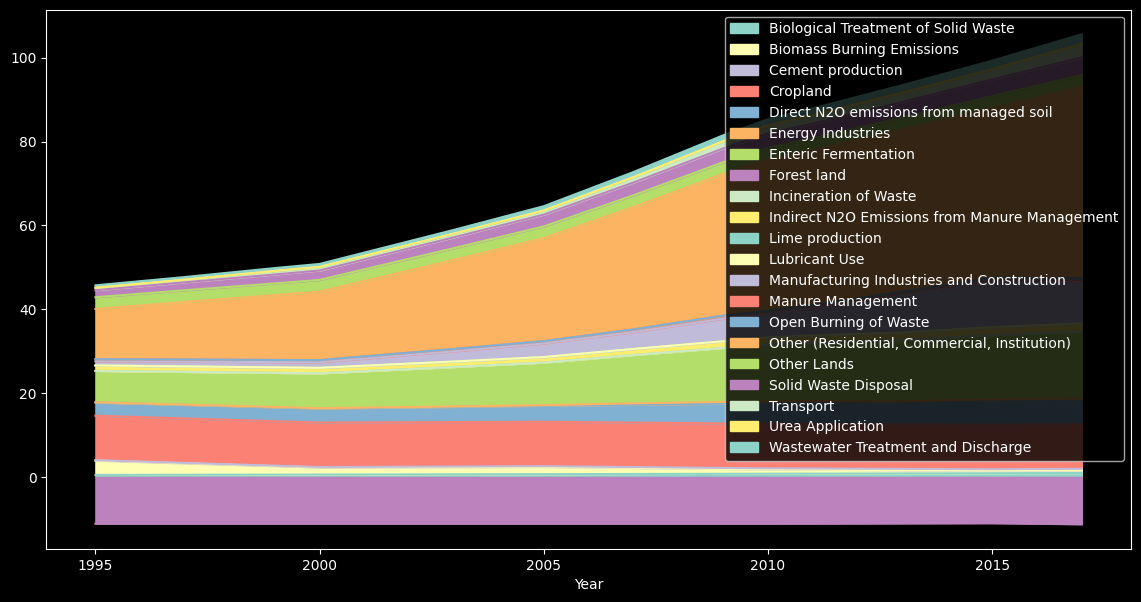

In [191]:
fig, ax = plt.subplots(figsize = (14, 7))

(
    sf.pivot_df_clean(
        df_pathways_out
        .get([_FIELD_SUBSECTOR, _FIELD_YEAR, _FIELD_VALUE])
        .groupby([_FIELD_SUBSECTOR, _FIELD_YEAR])
        .sum()
        .reset_index(),
        fields_column = [_FIELD_SUBSECTOR],
        fields_value = [_FIELD_VALUE],
    )
    .plot
    .area(
        ax = ax,
        x = _FIELD_YEAR, 
    )
)